In [20]:
%matplotlib inline

In [21]:
import os
import sys
import json
import pylab
import numpy as np
import matplotlib.ticker
from dateutil import parser
from scipy import interpolate
from matplotlib.dates import date2num
from datetime import timedelta, datetime
from pysurvey.plot import setup, dateticks, minmax, hcolorbar, line, icolorbar

In [22]:
%%bash
rsync -ravpP gpi:.temperature.neon.log ~/.temperature.neon.log
rsync -ravpP gpi:.uptime.neon.log ~/.uptime.neon.log

# ../bin/get_temperature.sh

receiving file list ... 
1 file to consider

sent 20 bytes  received 90 bytes  44.00 bytes/sec
total size is 4225280  speedup is 38411.64
receiving file list ... 
1 file to consider

sent 20 bytes  received 85 bytes  30.00 bytes/sec
total size is 5213948  speedup is 49656.65


In [23]:
FILENAME = os.path.expanduser('/Users/ajmendez/.temperature.neon.log')
SEP = ' : '
YR = [29,60]
TNORM = 40


In [24]:

def read_temps(filename=FILENAME):
    out = []
    with open(filename, 'r') as f:
        lines = f.readlines()
        for line in lines:
            items = line.split(SEP)
            out.append(dict(date=parser.parse(items[1]),
                            temperature=float(items[2])/1000.0))
    return out
data = read_temps()


In [25]:
def get_continuum(dates, x, y, delta):
    out = []
    t = timedelta(hours=delta)
    for d in dates:
        ii = np.where( (date2num(x) >  date2num(d-t) ) &
                       (date2num(x) <= date2num(d+t) ) )[0]
        if len(ii) <= 20:
            out.append(-1)
        else:
            out.append( np.mean(y[ii]) )
    
    
    t = date2num(dates)
    n = np.min(t)
    tmp = np.array(out)
    ii = np.where(tmp > 0)
    f = interpolate.UnivariateSpline(date2num(dates[ii])-n,tmp[ii], s=4)
    return f(t-n)

def get_continuum(dates, x, y, delta=2):
    out = []
#     t = timedelta(hours=delta)
    tmp = date2num(x)
    nd = date2num(dates)
    for d in nd:
        t = np.abs(tmp-d)
        ii = np.where( t < delta/24.0)[0]
        if len(ii) <= 20:
            out.append(-1)
        else:
            out.append( np.mean(y[ii]) )
#             out.append(np.min(y[ii]))
#     return np.array(out)
    
    tmp = np.array(out)
    n = np.min(nd)
    ii = np.where(tmp > 0)
    f = interpolate.UnivariateSpline(nd[ii]-n,tmp[ii], s=4)
    return f(nd-n)

    



dates, values = map(np.array, zip(*[(d['date'], d['temperature'])
                                    for d in data]))
ndates = date2num(dates)
tmp = (ndates % 1.0)*24.0
ii = np.where((tmp > 0) & (tmp < 10))[0]
# continuum = get_continuum(dates, dates[ii], values[ii])
continuum = np.convolve(np.ones(1000)/1000.0, values, mode='same')

In [26]:
continuum.shape, ndates.shape, dates.shape

((66020,), (66020,), (66020,))

In [27]:

def setupplot(secondax=False, **kwargs):
    ytickv = np.linspace(YR[0],YR[1],6)
    yticknames = map('{:0.0f}'.format, ytickv)
    tmp = dict(
        ylabel='Temperature [c]',
        yr=minmax(ytickv), ytickv=ytickv,
        yticknames=yticknames,
    )
    tmp.update(kwargs)
    ax = setup(**tmp)
    
    if secondax:
        subplt = kwargs.get('subplt',None)
        f = lambda x: '{:0.0f}'.format(1.8*x + 32.0)
        yticknames = map(f, ytickv)
        ax2 = ax.twinx()
        ax2.set_ylabel(r"Temperature [F]")
        ax2.set_ylim(minmax(ytickv))
        ax2.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(ytickv))
        ax2.yaxis.set_major_formatter(matplotlib.ticker.FixedFormatter(yticknames))
        pylab.sca(ax)
        
        # setup(ax=ax.twinx(),
        #       subplt=subplt,
        #       ylabel='Temperature [F]',
        #       yr=minmax(ytickv), ytickv=ytickv, yticknames=yticknames)
        
    
    return ax

66020


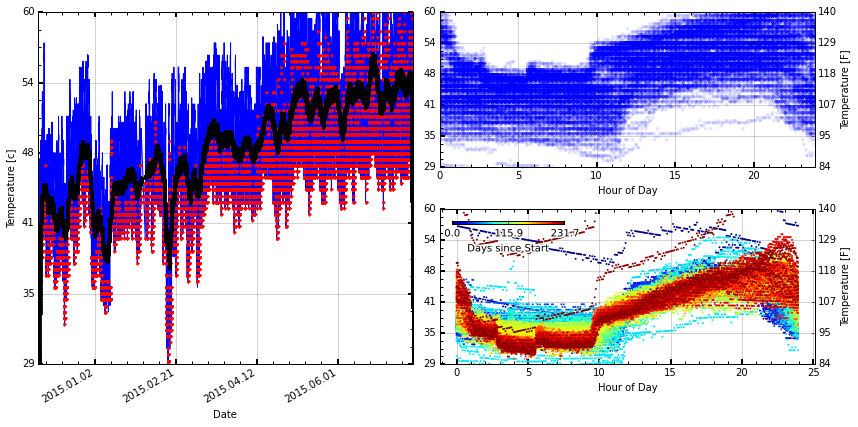

In [28]:
def plot_temp():
    setup(figsize=(12,6))
    
    setupplot(subplt=(1,2,1), autoticks=True, xlabel='Date',)
    pylab.plot(ndates, values)
#     pylab.scatter(dates, values, c=ndates, 
#                   cmap=pylab.cm.spectral, edgecolor='none', marker='.')
    pylab.plot(ndates[ii], values[ii], '.r')
    pylab.plot(ndates, continuum, '.k')
#     plot_weather(np.min(date2num(dates)))
    # pylab.plot(dates, values-continuum+38, '.r')
    dateticks('%Y.%m.%d')
    
    
    setupplot(subplt=(2,2,2), autoticks=False, xlabel='Hour of Day')
    pylab.plot(tmp, values, '.', alpha=0.1)
    setupplot(subplt=(2,2,2), ylabel='', secondax=True)
    
    
    
    setupplot(subplt=(2,2,4), autoticks=False, xlabel='Hour of Day')
    jj = np.where(np.isfinite(tmp) & 
                  np.isfinite(values) & 
                  np.isfinite(continuum) & 
                  np.isfinite(ndates))[0]
    print len(jj)
    sc = pylab.scatter(tmp[jj], values[jj]-continuum[jj]+TNORM, 
                       c=ndates[jj]-np.min(ndates[jj]), s=15,
                       marker='.', edgecolor='none',
                       label='Days since Start')
    
    setupplot(subplt=(2,2,4), ylabel='', secondax=True)
#     hcolorbar(sc, axes=[0.6, 0.4, 0.1, 0.01])
    icolorbar(sc)
    
    pylab.tight_layout()
    pylab.show()
plot_temp()

66020


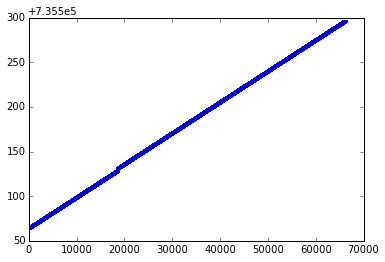

In [29]:
x = ndates
kk = np.where(np.isfinite(x))[0]
print len(kk)
pylab.plot(x[kk], '.')

624


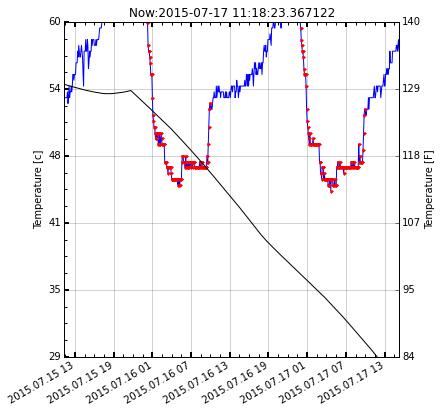

In [30]:
def plot_recent(delta=48):
    '''plot the last delta [48] hrs'''
    now = datetime.now()
    start = date2num(now - timedelta(hours=delta))
    jj = np.where(ndates > start)[0]
    print len(jj)
    
    setup(figsize=(6,6), xr=minmax(ndates[jj]))
    setupplot(secondax=True, title='Now:{}'.format(now))
    
    pylab.plot(dates, values)
    pylab.plot(dates[ii], values[ii], '.r')
    pylab.plot(dates, continuum, 'k')
    dateticks('%Y.%m.%d %H')
    line(now+timedelta(hours=5)) # to gmt

plot_recent()

6192


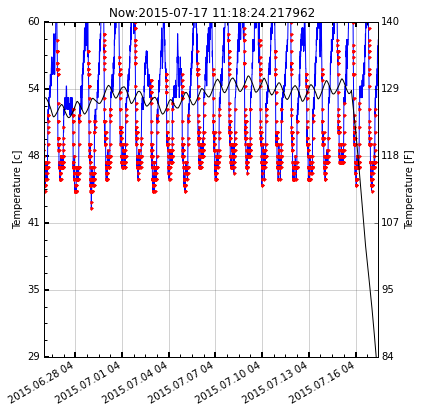

In [31]:
plot_recent(512)

624


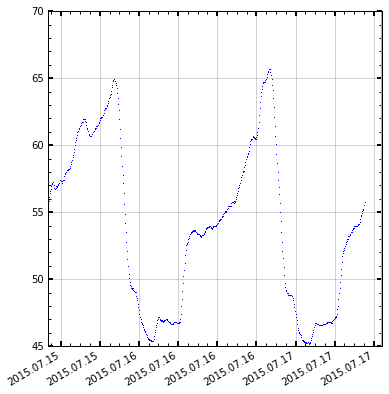

In [32]:
def plot_recent(delta=48):
    '''plot the last delta [48] hrs'''
    now = datetime.now()
    start = date2num(now - timedelta(hours=delta))
    ii = np.where(ndates > start)[0]
    print len(ii)
    
    setup(figsize=(6,6))
#     setupplot(secondax=True, title='Now:{}'.format(now))
    
    
    
#     pylab.plot(dates[ii], values[ii])  
    
    nsmooth = 10
    nend = nsmooth*2
    svalues = np.convolve(np.ones(nsmooth)/nsmooth, values[ii], mode='same')
    pylab.plot(dates[ii][nend:-nend], svalues[nend:-nend], ',')  
    
#     kk = np.where( (continuum[ii] > 30) & (continuum[ii] < 100) )
#     pylab.plot(dates[ii][kk], continuum[ii][kk], '.k')
    dateticks('%Y.%m.%d')
    line(now+timedelta(hours=5)) # to gmt

plot_recent(48)

3120


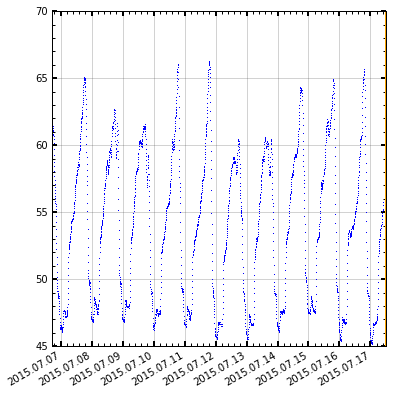

In [33]:
plot_recent(256)

In [34]:
tmp = np.genfromtxt('/Users/ajmendez/.uptime.neon.log', 
                    dtype=['S128'],
                    delimiter='|',
#                     dtype=[np.int64,'S32', 'S96']
                    )

In [35]:
x = tmp[0]
datetime.fromtimestamp(float(x[0].split()[0]))

datetime.datetime(2014, 11, 10, 12, 45, 1)

In [36]:
def get_5min(x):
    try:
        return float(x[0].split(',')[-3].split(' ')[-1])
    except Exception as e:
        print x[2]
        raise
        return None
def get_date(x):
    return datetime.fromtimestamp(float(x[0].split()[0]))
# get_date(tmp[0])
udate = map(get_date, tmp)
uptime = map(get_5min, tmp)

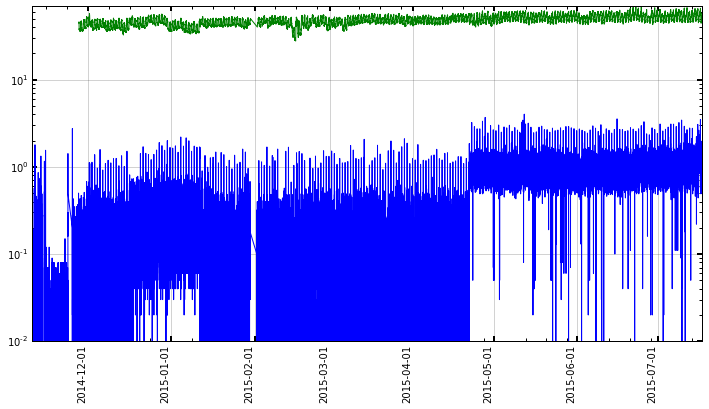

In [37]:
setup(figsize=(12,6), xr=minmax(udate), ylog=True )
pylab.plot(udate, uptime)
pylab.plot(dates, values)
dateticks('%Y-%m-%d', rotation=90)

[68623 68624 68625 ..., 70156 70157 70158]


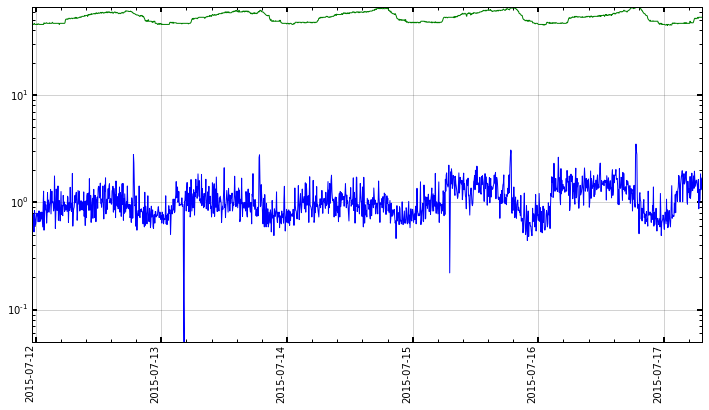

In [38]:
ndate = date2num(udate)
start = date2num(datetime.now() - timedelta(hours=128))
ii = np.where(ndate > start)[0]
jj = np.where(ndates > start)[0]
print ii
setup(figsize=(12,6), xr=minmax(ndate[ii]), ylog=True )
pylab.plot(ndate[ii], np.array(uptime)[ii])
pylab.plot(dates[jj], values[jj])
dateticks('%Y-%m-%d', rotation=90)

In [39]:
utemp = np.interp(date2num(udate), date2num(dates), values)

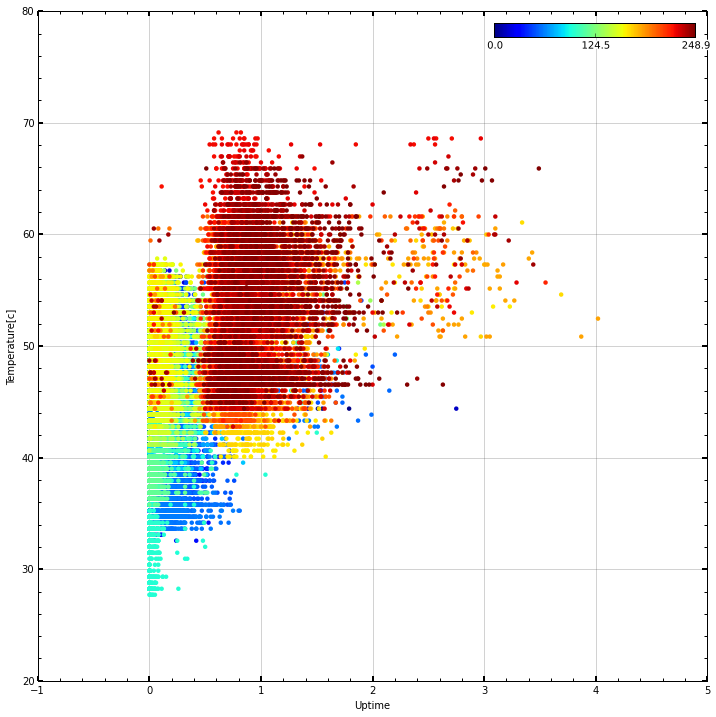

In [40]:
setup(figsize=(12,12),
      xlabel='Uptime', ylabel='Temperature[c]')
c = date2num(udate)
c -= np.min(c)

# pylab.plot(uptime, utemp, '.')
sc = pylab.scatter(uptime, utemp, c=c, edgecolor='none')
_ = icolorbar(sc, loc=1)